Import Statements
---

In [ ]:
!pip install biopython # otherwise the data_prep_functions will not be imported!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
data_prep_path = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/'
sys.path.append(data_prep_path)

from copy_data_prep_functions import *

import threading
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import  spearmanr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.model_selection import StratifiedKFold

Mounted at /content/drive
test: 7.2.24 v12


Data Preparation
--
Linking to DataFrame(s) of interest

In [ ]:
# Specify input directory filepath
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/'

# Initialize an empty list to store Excel file paths
excel_files = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    # Check if the file is an Excel file
    if file.endswith('.xlsx'):
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)
        # Append the file path to the list
        excel_files.append(file_path)

# Print the list of Excel file paths to verify proper list appending
print(excel_files)

['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/df_Bov Swiss Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/df_NormBov Swiss Intensity.xlsx']


DataFrame Clean Up


*   Remove zeros and NaN
*   Replace with the second lowest found value for Abundance



In [ ]:
# Iterate over each Excel file
for file in excel_files:
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file, header=0)

    # Get the minimum control value
    Min_Control = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Control, inplace=True)

    # Filter out rows with abundance values below zero
    Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df = df[df['Abundance'] >= Min_Abundance]

    # Extract the filename without extension
    file_name = os.path.splitext(os.path.basename(file))[0]

    # Specify the output file path with the current filename included
    output_file_path = os.path.join('/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs', f'{file_name}.xlsx')
    df.to_excel(output_file_path, index=False)

Make Train/Test Split; 90% Train, 10% Test, two Excel files

In [ ]:
# Load the CLEANED (above code cell) data from an Excel file into a pandas DataFrame
file_name = 'Norm Bov SP Intensity'
data_file_path = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx'
data = pd.read_excel(data_file_path)

# Split the data into 90% for training and 10% for testing
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

# Specify the file paths where you want to save the Excel files
train_file_path = (f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_{file_name}.xlsx')
test_file_path = (f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_{file_name}.xlsx')

# Save the training data to the specified Excel file
train_data.to_excel(train_file_path, index=False)

# Save the test data to the specified Excel file
test_data.to_excel(test_file_path, index=False)

print(f"Train dataset saved to {train_file_path}")
print(f"Test dataset saved to {test_file_path}")


Train dataset saved to /content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_Norm Bov SP Intensity.xlsx
Test dataset saved to /content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_Norm Bov SP Intensity.xlsx


Initial Model Training & Important Feature Determination
--

Initializing Standard Pipeline - Threaded

In [ ]:
# Specify input directory filepath
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/'

# Initialize an empty list to store Excel file paths
processed_files = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    # Check if the file is an Excel file
    if file.endswith('.xlsx'):
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)
        # Append the file path to the list
        processed_files.append(file_path)

# Print the list of Excel file paths to verify proper list appending
print(processed_files)

['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_90_percent.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_10_percent.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_Bov SP Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_Bov SP Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_NormBov Swiss Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_Norm Bov SP Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/t

Specifying directory and files to be used in model

In [ ]:
# For shorter computing time, run one file at a time
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/'

#file_beginning = 'df_'
#file_group = 'Bov Swiss'
#file_ending = ' Intensity_no_AC.xlsx'  # options are ' Intensity.xlsx', ' Top3.xlsx', ' iBAQ.xlsx'
#target_file = file_beginning + file_group + file_ending  # This constructs the exact target file name

target_file = 'train_data_Norm Bov SP Intensity.xlsx'

files = []

for file in os.listdir(input_directory):
    if file == target_file:  # Use exact match instead of partial matches
        files.append(file)

print(files)

['train_data_Norm Bov SP Intensity.xlsx']


**RFECV**

ANOVA

In [ ]:
def calculate_anova(X, y):
    f_values, p_values = f_regression(X, y)
    return f_values, p_values

def rank_features_by_anova(X, y, feature_names):
    full_name_dict = {
        'Abundance_Controls' : 'Control Abundance',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_var': 'Flexibility - Variance',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'flexibility_median': 'Flexibility - Median',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_median': 'Relative Surface Area - Median',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_total_exposed_A': '% Exposed Amino Acid A / Total Amino Acids',
          'fraction_total_exposed_C': '% Exposed Amino Acid C / Total Amino Acids',
          'fraction_total_exposed_D': '% Exposed Amino Acid D / Total Amino Acids',
          'fraction_total_exposed_E': '% Exposed Amino Acid E / Total Amino Acids',
          'fraction_total_exposed_F': '% Exposed Amino Acid F / Total Amino Acids',
          'fraction_total_exposed_G': '% Exposed Amino Acid G / Total Amino Acids',
          'fraction_total_exposed_H': '% Exposed Amino Acid H / Total Amino Acids',
          'fraction_total_exposed_I': '% Exposed Amino Acid I / Total Amino Acids',
          'fraction_total_exposed_K': '% Exposed Amino Acid K / Total Amino Acids',
          'fraction_total_exposed_L': '% Exposed Amino Acid L / Total Amino Acids',
          'fraction_total_exposed_M': '% Exposed Amino Acid M / Total Amino Acids',
          'fraction_total_exposed_N': '% Exposed Amino Acid N / Total Amino Acids',
          'fraction_total_exposed_P': '% Exposed Amino Acid P / Total Amino Acids',
          'fraction_total_exposed_Q': '% Exposed Amino Acid Q / Total Amino Acids',
          'fraction_total_exposed_R': '% Exposed Amino Acid R / Total Amino Acids',
          'fraction_total_exposed_S': '% Exposed Amino Acid S / Total Amino Acids',
          'fraction_total_exposed_T': '% Exposed Amino Acid T / Total Amino Acids',
          'fraction_total_exposed_V': '% Exposed Amino Acid V / Total Amino Acids',
          'fraction_total_exposed_W': '% Exposed Amino Acid W / Total Amino Acids',
          'fraction_total_exposed_Y': '% Exposed Amino Acid Y / Total Amino Acids',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y / Total Exposed',
          'asa_sum_normalized': 'Sum of Absolute Surface Area / Total Mass',
          'nsp_secondary_structure_helix': '% Secondary Structure - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered'
    }

    f_values, p_values = calculate_anova(X, y)
    full_feature_names = [full_name_dict.get(name, name) for name in feature_names]

    feature_importances = pd.DataFrame({
        'Feature': full_feature_names,
        'F-Value': f_values,
        'P-Value': p_values
    })

    ranked_features = feature_importances.sort_values(by='F-Value', ascending=False)
    return ranked_features

def plot_top_features(ranked_features, name):
    top_features = ranked_features.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features['Feature'], top_features['F-Value'], color='black')
    ax.set_xlabel('F-Value', fontweight='bold', color='black')
    ax.set_title(f'Top 10 Features Ranked by ANOVA for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
def process_file(in_df, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100)

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # 'Abundance' column in df represents a 1D array of target values (class labels)
    y_label = np.log2(df['Abundance'].to_numpy().astype(float))

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # RFECV Variables
    identifier = 'neg_mean_squared_error'
    keep_columns = ['Abundance', 'NPUNID', 'Entry']
    n_splits = 10 # changed just to see plot, go back to 10 later
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1] # equal to number of columns in df
    min_features = 1

    selected_features = None
    current_score = float(100)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg neg_mean_squared_err": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})
    print('start', name)

    for n_features_to_select in range(max_features, min_features, -1):
        print('n_features_to_select', n_features_to_select)
        avg_accuracies = []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            # Assert statement used to ensure no train/test split overlap
            assert len(set(train_index) & set(test_index)) == 0, "Overlap found between training and testing sets"

            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Evaluate on validation set
            y_pred=model.predict(X_test)
            accuracy = mean_squared_error(y_pred, y_test)
            avg_accuracies.append(accuracy)

            # At each iteration, each feature will get an importance
            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Compute average accuracy across all folds
        avg_accuracy = np.mean(avg_accuracies)
        std_dev = np.std(avg_accuracies)

        # If this is the best combo, save it
        combined_score = avg_accuracy + std_dev + (n_features_to_select / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features_to_select, avg_accuracy, std_dev, ", ".join(df.columns),combined_score]

        # Drop the feature with the lowest importance sum
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score < current_score:
            current_score = combined_score
            # Selecting the best features of the current df
            best_features = df.columns.tolist()

    print("Best Feature Names:", best_features)

    # Save RFECV results and scores
    # Manually selected file path to save to
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/RFECV_RFR_results_{name}_v3.csv', index=False)
    feat_list = best_features + keep_columns

    # Run scorer to determine feature importance and metrics for each df
    df = df_original[best_features].copy()
    RFR_scores, feats = scorer(df, y_label, model, identifier=identifier, folds=n_splits)

    # Manually selected file path to save to
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/Feats_RFECV_{name}_v3.xlsx', index=False)
    # Manually selected file path to save to
    RFR_scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/Scores_RFECV_{name}_v3.xlsx', index=False)

    df_RFECV = df_original[feat_list].copy()
    # Manually selected file path to save to
    df_RFECV.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_{name}_v3.csv', index=False)

    # Compute feature importances and print them
    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)


    # Calculate ANOVA
    ranked_features = rank_features_by_anova(df[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)
    top_10_features.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/ANOVA_top_features_{name}_no_AC')
    plot_top_features(top_10_features, name)
    print(top_10_features)

    # Plot RFECV results

    # Plot RFECV results for MSE
    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    n_features = df_full_results["Number of features"]
    mse_mean = df_full_results["Avg neg_mean_squared_err"]
    mse_std = df_full_results["Std dev"]

    # Plotting the mean values
    ax.plot(n_features, mse_mean, label='Negative MSE', color='black', marker='o', markersize=4)
    # Adding the shaded area for standard deviation
    ax.fill_between(n_features, mse_mean - mse_std, mse_mean + mse_std, color='black', alpha=0.2)

    # Setting labels and title with customized options
    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Negative Mean Squared Error', fontweight='bold', color='black')

    # Change the title for proper publication format
    #ax.set_title(f'RFR Model: RFECV Results for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')

    # Adjusting the tick parameters to match the RFC plot style
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    # Adding grid lines for better readability
    ax.grid(False)

    # Moving the legend to a less obtrusive location
    #ax.legend(loc='upper right', fontsize='large', bbox_to_anchor=(0.87, 0.75), borderaxespad=0.5, frameon=True)


    # Saving the plot to the specified path
    # Manually selected file path to save to
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/RFECV_plot_{name}_v3.png')
    plt.show()
    plt.close()

    print(name, 'done')

# Initialize an empty list to store threads
threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        # Create a thread that runs process_file on each Excel file
        thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")

train_data_Norm Bov SP Intensity
start train_data_Norm Bov SP Intensity
n_features_to_select 80
n_features_to_select 79
n_features_to_select 78
n_features_to_select 77
n_features_to_select 76
n_features_to_select 75
n_features_to_select 74


KeyboardInterrupt: 

Predicting - Protein
----

Specifying directory and files to be used in protein prediction model

Currently setup to train and test on FBS protein only, no predicting across proteomes yet.

predicting with 10 percent test dataset/excel file

In [ ]:
def convert_csv_to_xlsx(csv_file, xlsx_file):
    df = pd.read_csv(csv_file)  # Read the csv file
    df.to_excel(xlsx_file, index=False)  # Save it as an xlsx file

# Example usage
convert_csv_to_xlsx('/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_train_data_Bov SP Intensity_v3.csv',
                    '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_train_data_Bov SP Intensity_v3.xlsx')

Pearson: 0.898502695209969
Spearman: 0.8668676814465589
R-squared: 0.8034690165359765
Mean Squared Error: 2.4620934276840143


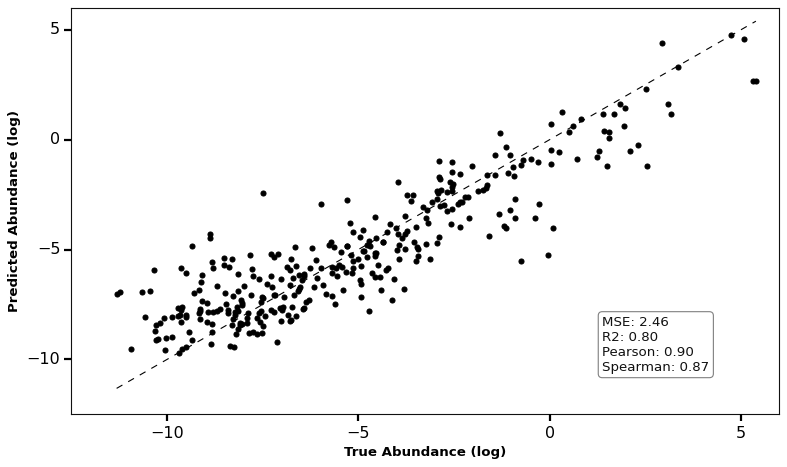

Model evaluation for Bovine SP Intensity v3 is complete!


In [ ]:
def predict_file(train_file, test_file, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Read the input training DataFrame
    df_train = pd.read_excel(train_file, header=0)

    # Filter out rows with abundance values below zero (assume missing or zero values)
    Min_Abundance = df_train['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df_train = df_train[df_train['Abundance'] >= Min_Abundance]

    # Log-transform the 'Abundance' target variable for training
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns in both training and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)

    # Read the input test DataFrame
    df_test = pd.read_excel(test_file, header=0)
    Min_Abundance = df_test['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df_test = df_test[df_test['Abundance'] >= Min_Abundance]

    # Log-transform the 'Abundance' target variable for testing
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    selected_features = df_train.columns

    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Create the figure and axes object with specific figure size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set the figure resolution
    plt.rcParams['figure.dpi'] = 300

    # Plotting the scatter data with customized color and plot line for identity
    ax.scatter(y_test, y_pred, color='black', s=20)  # Adjust marker size with `s`
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Identity line

    # Setting labels and title with customized options
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')

    # Setting plot title
    #ax.set_title(f'RFR Model: Predicted vs True Abundance (Log) Bov Swiss-Prot Intensity', fontweight='bold', color='black')

    # Adjusting the tick parameters to match the RFC plot style
    ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)

    # Add a metrics box to the plot
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Remove grid lines
    ax.grid(False)

    # Ensure the layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Save the plot
    #plt.savefig(f'{name}_RFR_Pred_vs_True_.png')

    # Close the plot explicitly to free up memory
    plt.close()

    # Save the evaluation metrics (you can add logic here to save it to an Excel file if needed)

    print(f"Model evaluation for {name} is complete!")


# Call the function for a single file without threading
predict_file('/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_train_data_Bov SP Intensity_v3.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_Bov SP Intensity.xlsx', 'Bovine SP Intensity v3')


Predicting - Nanoparticle
---


[29, 27, 33, 18, 25, 17, 32, 34, 21, 26, 22, 19, 28, 23, 24, 20, 31, 35, 30]


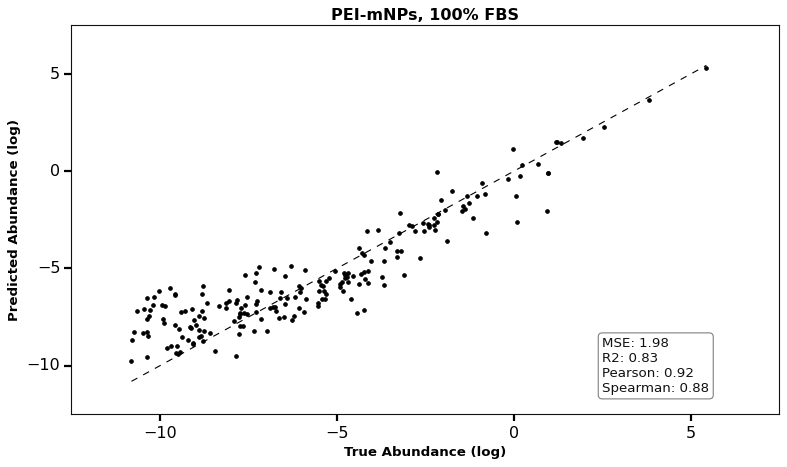

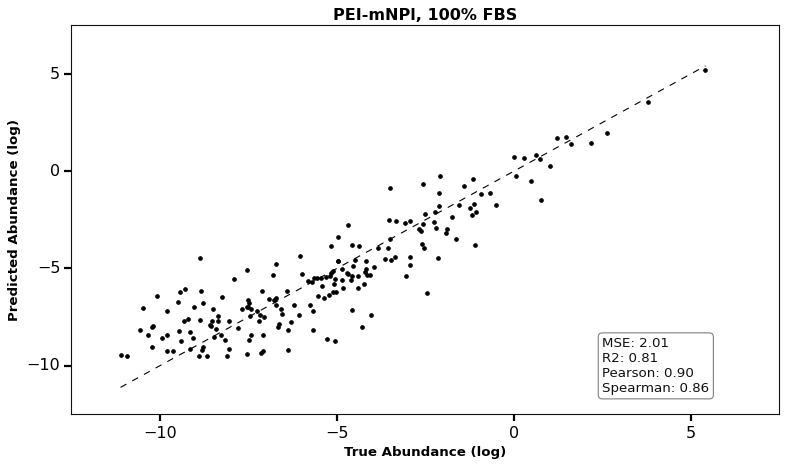

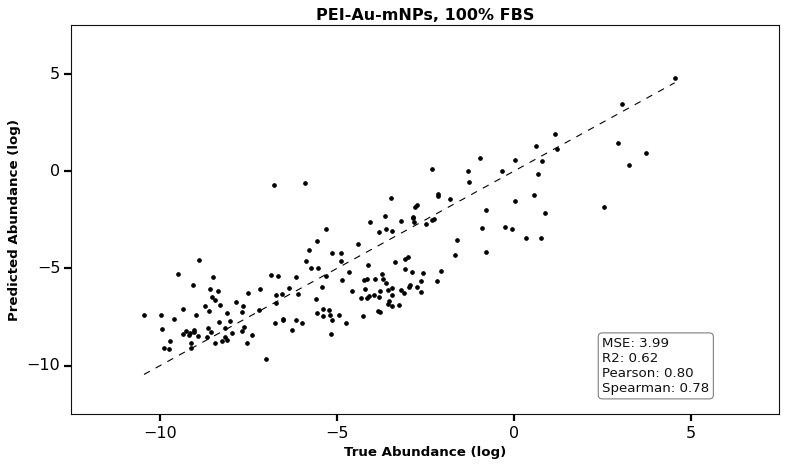

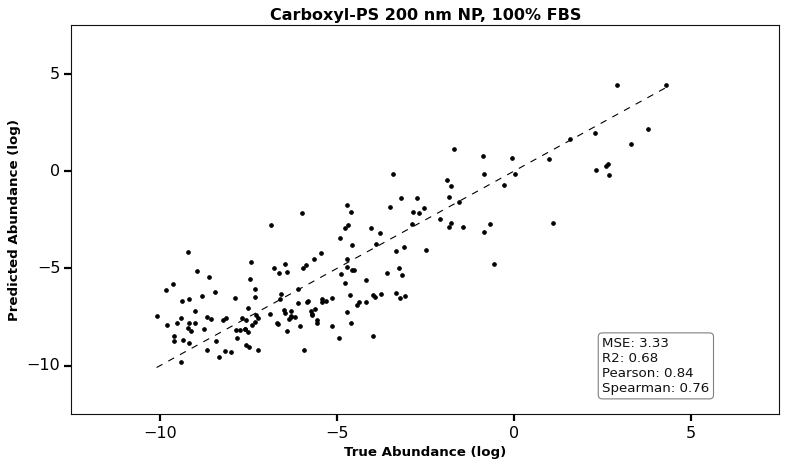

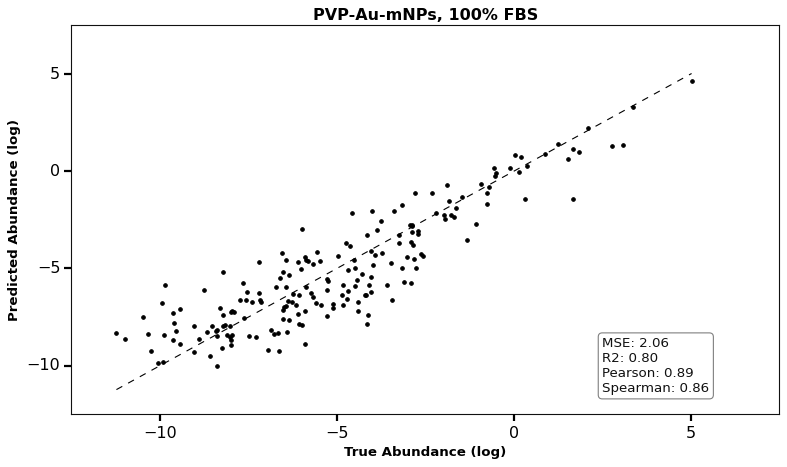

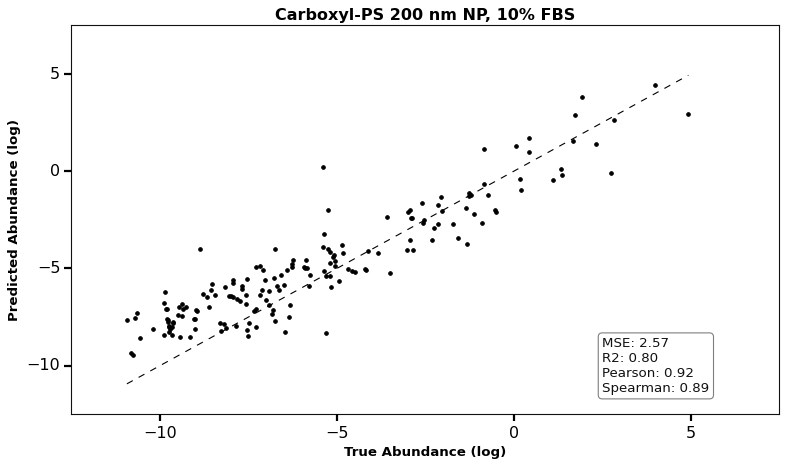

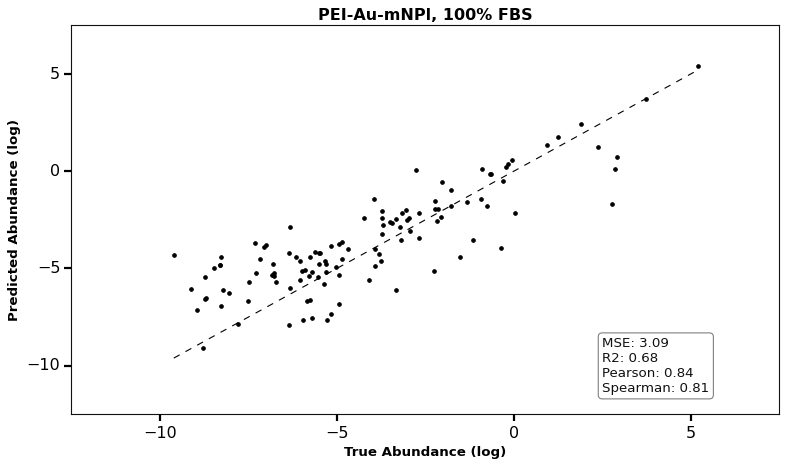

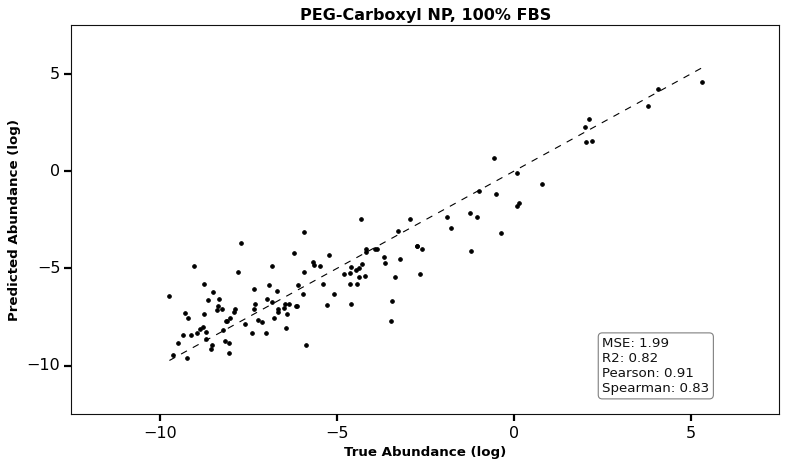

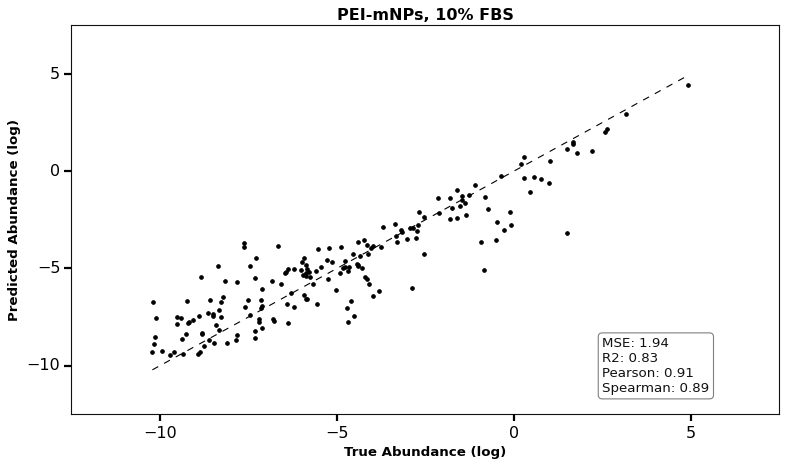

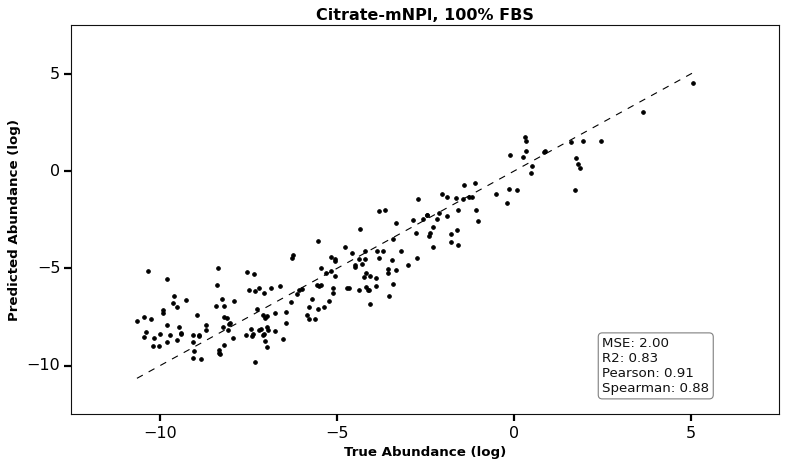

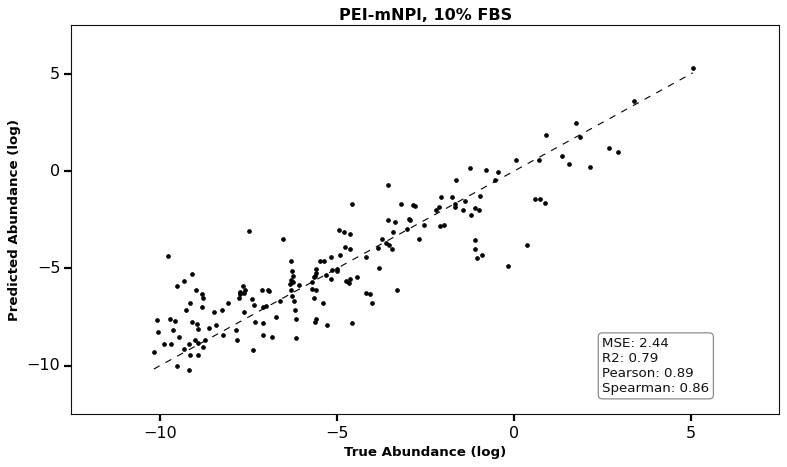

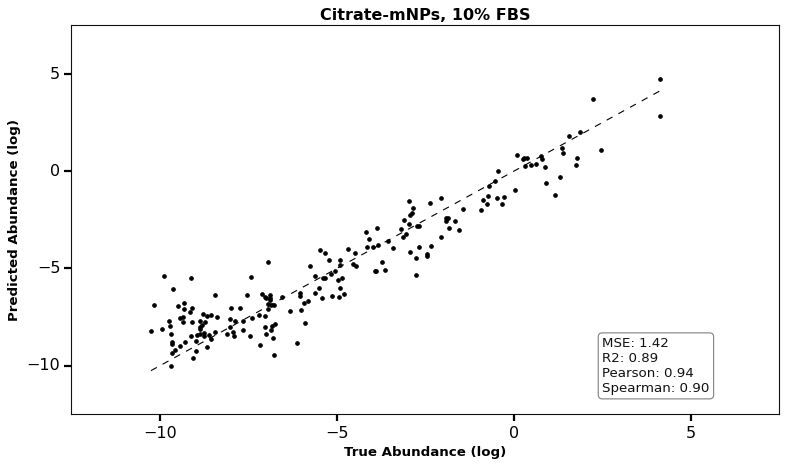

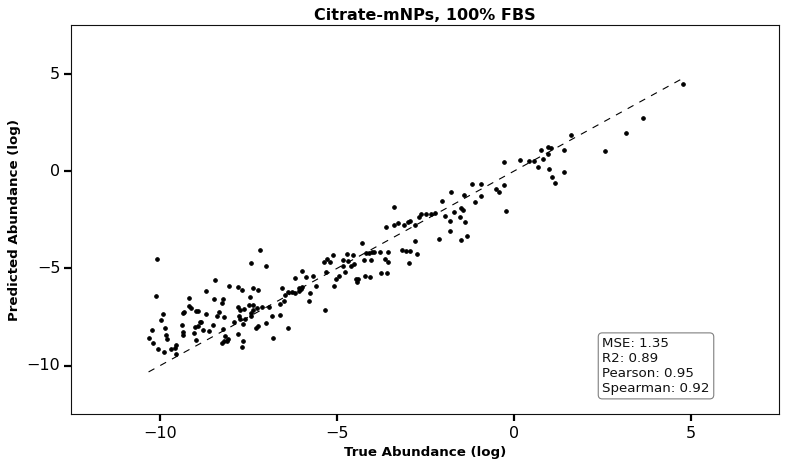

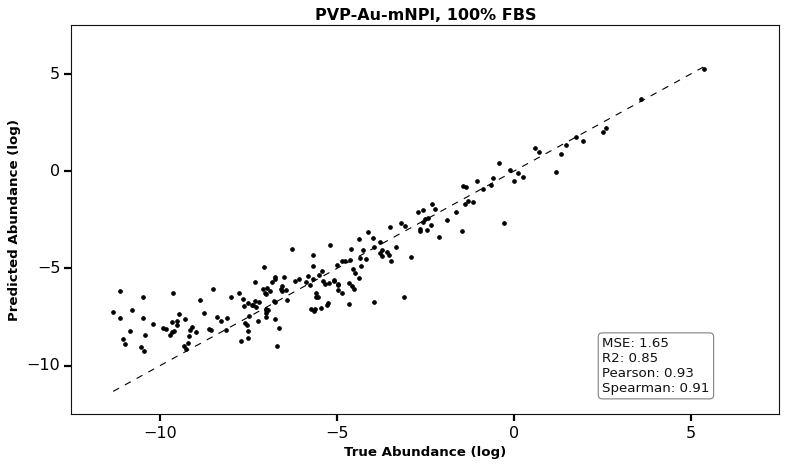

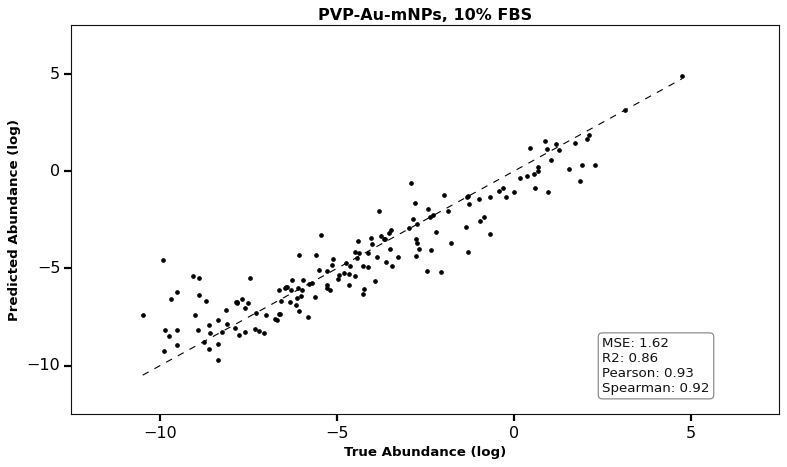

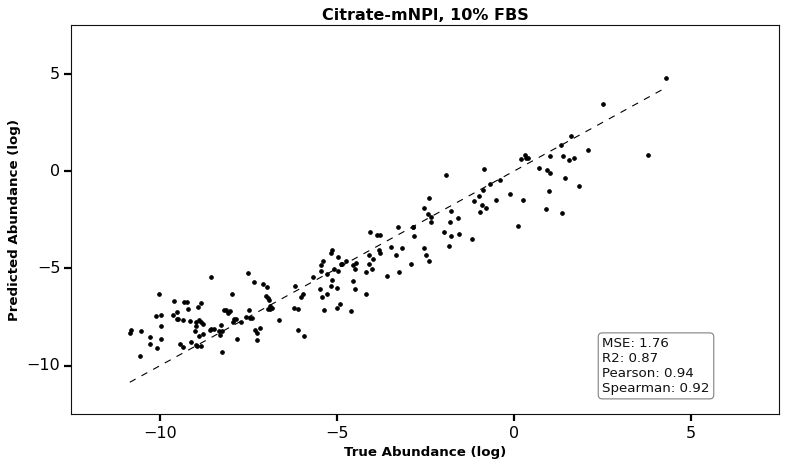

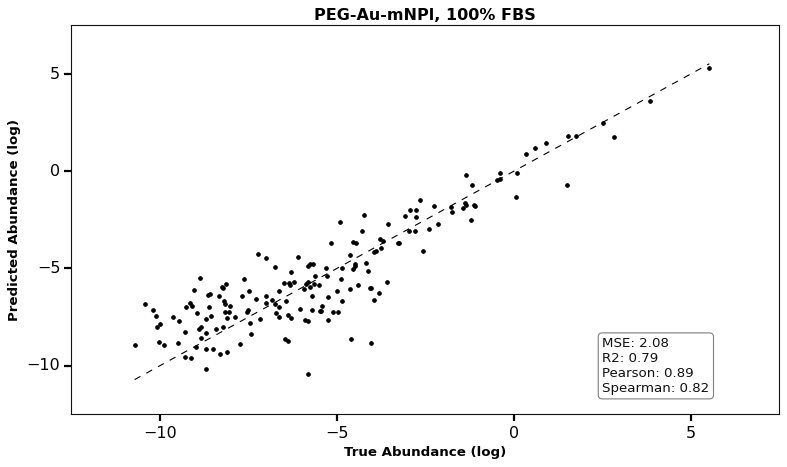

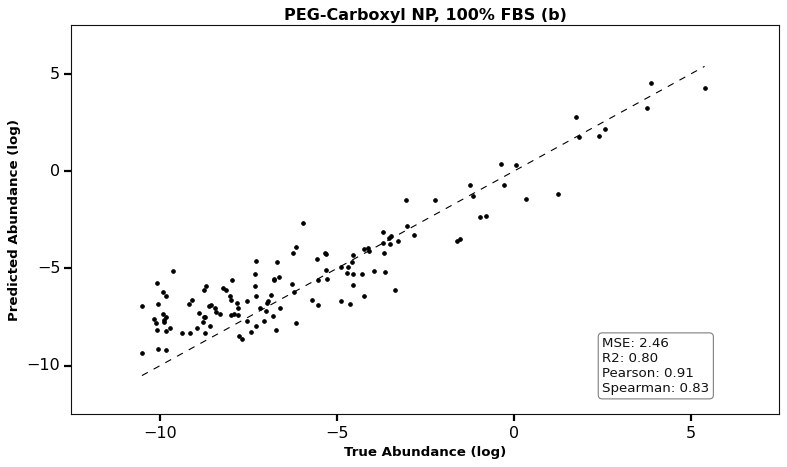

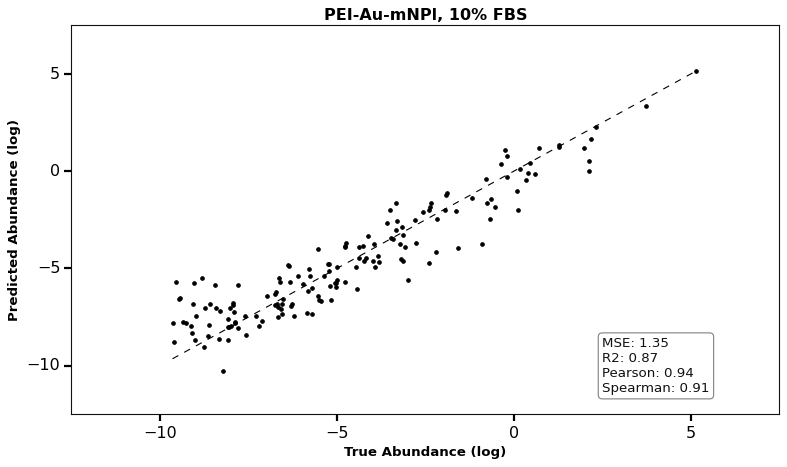

    Pearson  Spearman  R-squared  Mean Squared Error  \
0  0.917059  0.877857   0.827396            1.980827   
0  0.898797  0.862692   0.807180            2.014936   
0  0.804723  0.780397   0.623523            3.989657   
0  0.835493  0.758194   0.683275            3.326399   
0  0.894823  0.863702   0.796229            2.064955   

                                ID  
0               PEI-mNPs, 100% FBS  
0               PEI-mNPl, 100% FBS  
0            PEI-Au-mNPs, 100% FBS  
0  Carboxyl-PS 200 nm NP, 100% FBS  
0            PVP-Au-mNPs, 100% FBS  


In [ ]:
npunid_to_full_name = {
    17: "Carboxyl-PS 200 nm NP, 10% FBS",
    18: "Carboxyl-PS 200 nm NP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-Carboxyl NP, 100% FBS",
    35: "PEG-Carboxyl NP, 100% FBS (b)"
}

def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100)

    # Filter out rows with abundance values below zero for train_set
    Min_Abundance = train_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    train_set = train_set[train_set['Abundance'] >= Min_Abundance].copy()

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents a 1D array of target values (class labels)
    label_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in train_set.columns]
    train_set.drop(columns=columns_to_drop, inplace=True)
    selected_features = train_set.columns.tolist()

    # Filter out rows with abundance values below zero for test_set
    Min_Abundance = test_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    test_set = test_set[test_set['Abundance'] >= Min_Abundance].copy()

    label_pred = np.log2(test_set['Abundance'].to_numpy().astype(float))

    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()
    y_train = label_train
    y_test = label_pred

    # Train the classifier
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Creating the figure and axes object with a specified size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set high resolution for clearer output
    plt.rcParams['figure.dpi'] = 300

    # Scatter plot of true vs. predicted values using adjusted color and marker size
    ax.scatter(y_test, y_pred, color='black', s=10)  # Using black for consistency and adjusting marker size

    # Identity line with adjusted color and line style
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

    # Setting labels, title with customized options
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)

    # Add a metrics box to the plot with consistent styling
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Adjusting the tick parameters for consistency
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    # Remove grid lines for a cleaner look
    ax.grid(False)

    # Ensure layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Close the plot explicitly to free up memory
    plt.close()

    results = pd.DataFrame({
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "Mean Squared Error": [mse],
        "ID": name  # This assumes 'name' is intended to be the identifier for the row
    })

    return results



# Manually selected file for 1) original (cleaned) df and 2) RFR RFECV results (to get best_features)
original_df = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx'
feats_from_rfr_rfecv = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_train_data_Bov SP Intensity_v3.xlsx'

df = pd.read_excel(original_df, header=0)
df_feats = pd.read_excel(feats_from_rfr_rfecv, header=0)

# Extract the list of column names from df_feats
# Assuming df_feats has a column called 'Features' or similar that contains the feature names
feats_columns = df_feats.columns.tolist()

# Filter df to only include the columns that match feats_columns, making a copy
df_filtered = df[feats_columns].copy()
# Create new evaluation df that will have the results of everything appended to it
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df['NPUNID'].unique().tolist()
print(np_ids)



for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df_filtered.loc[df['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df_filtered.loc[df['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFR model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test to the full evaluation df
    full_eval = pd.concat([full_eval, eval])

print(full_eval.head())

Predicting NP information; correlations made with NPUNID IDs

[29, 27, 33, 18, 25, 17, 32, 34, 21, 26, 22, 19, 28, 23, 24, 20, 31, 35, 30]


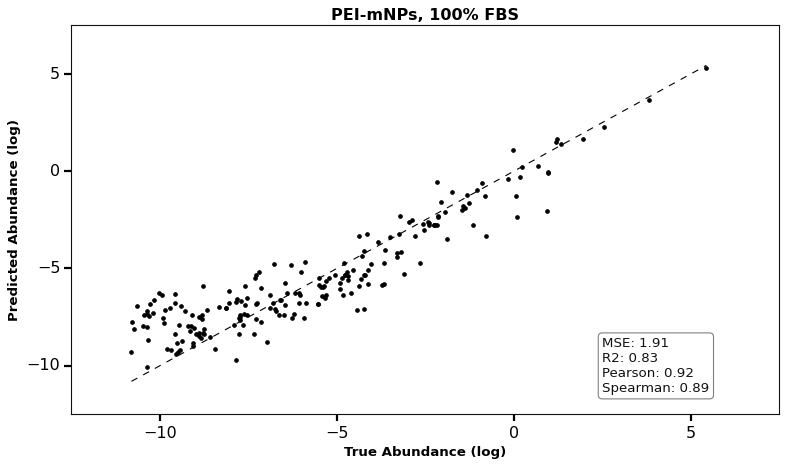

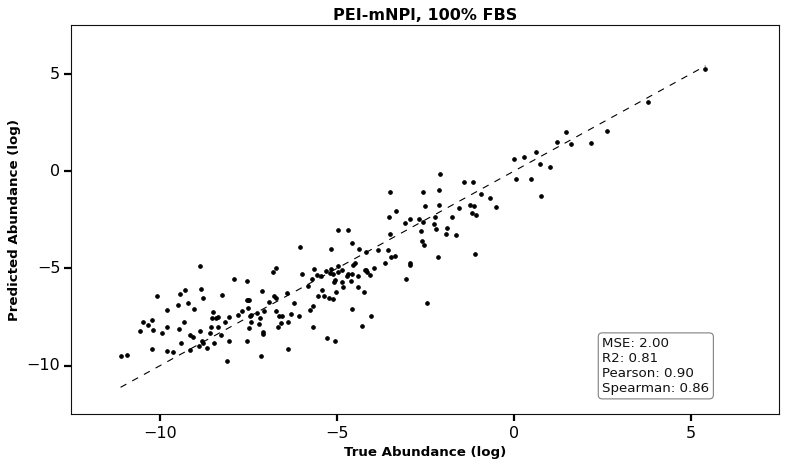

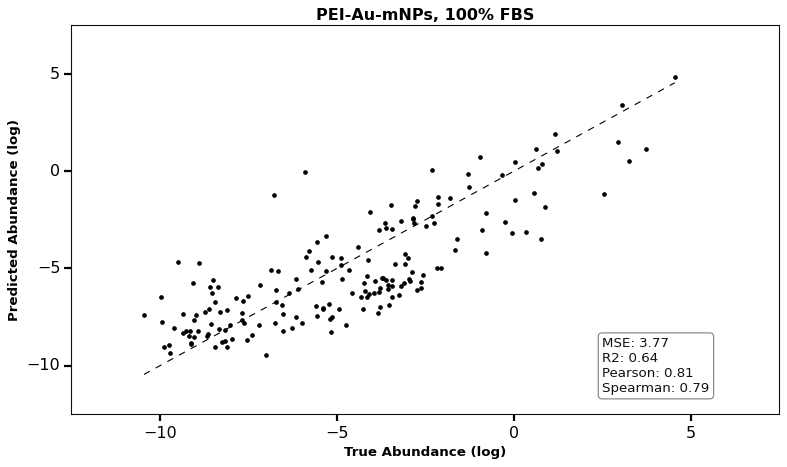

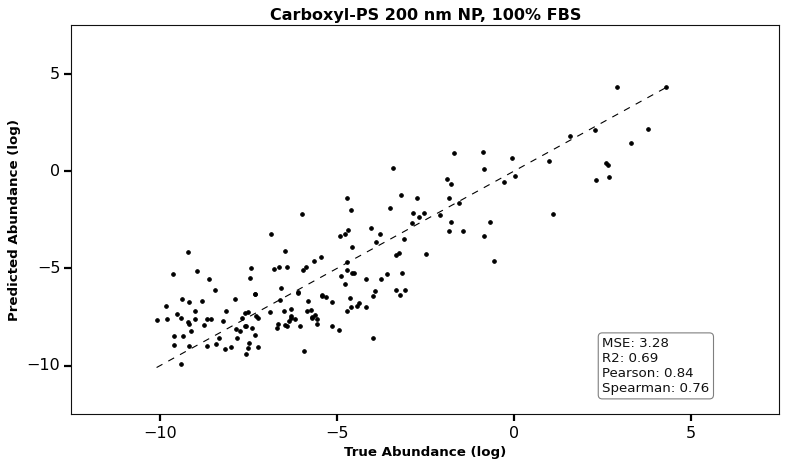

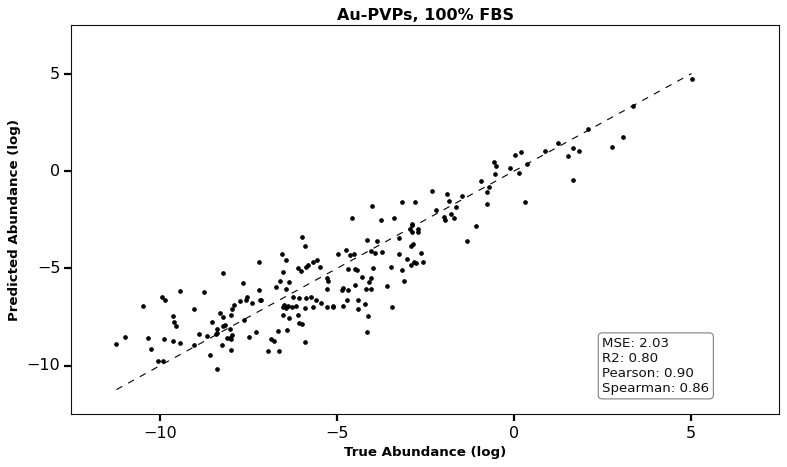

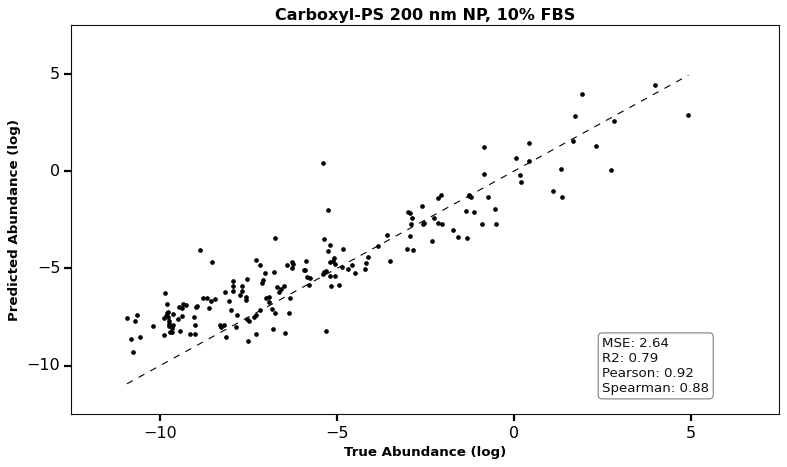

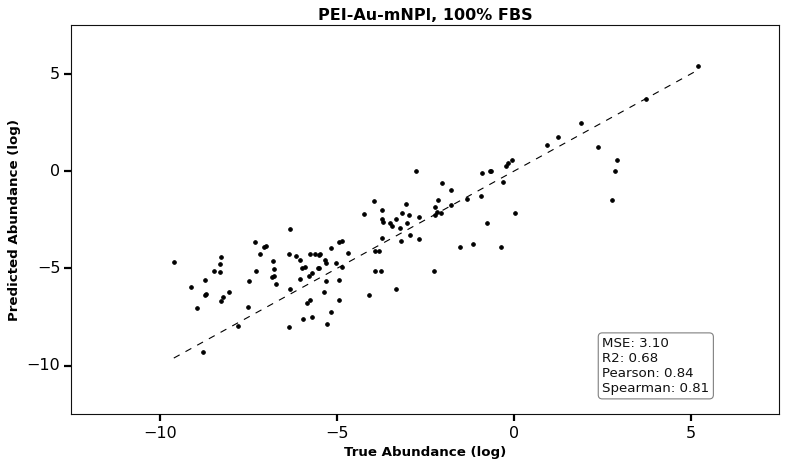

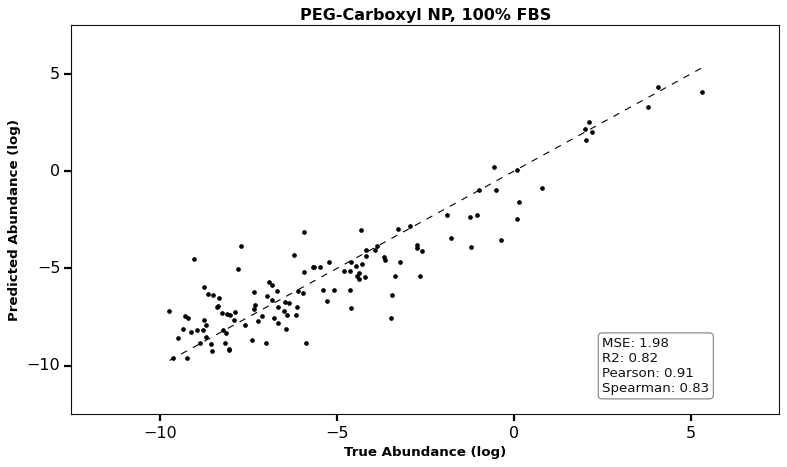

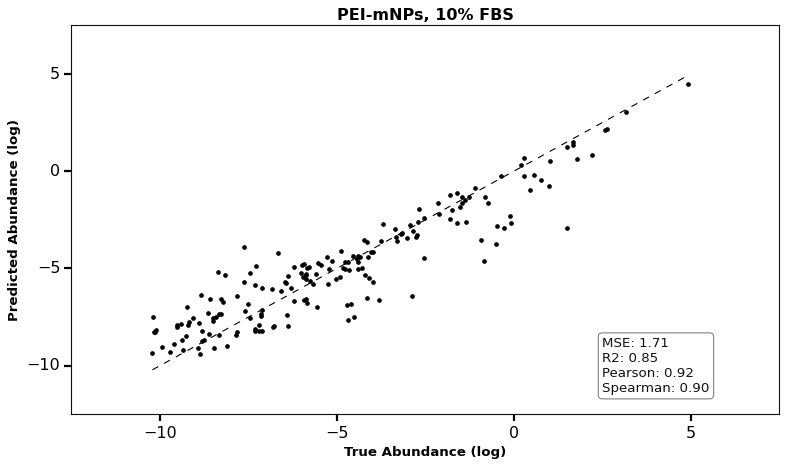

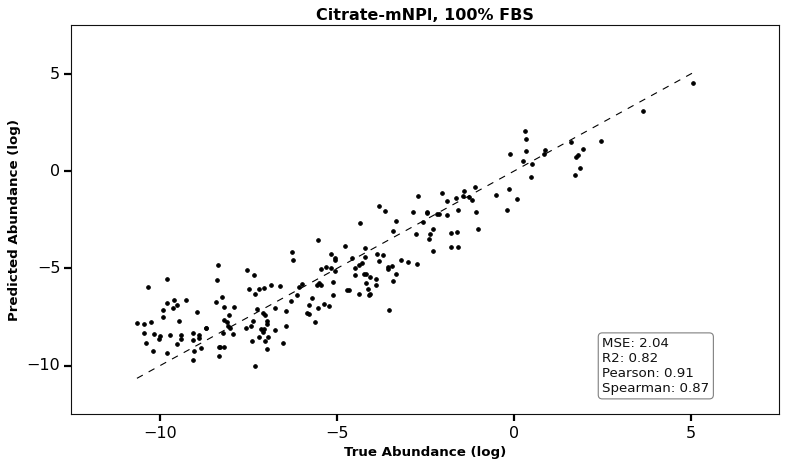

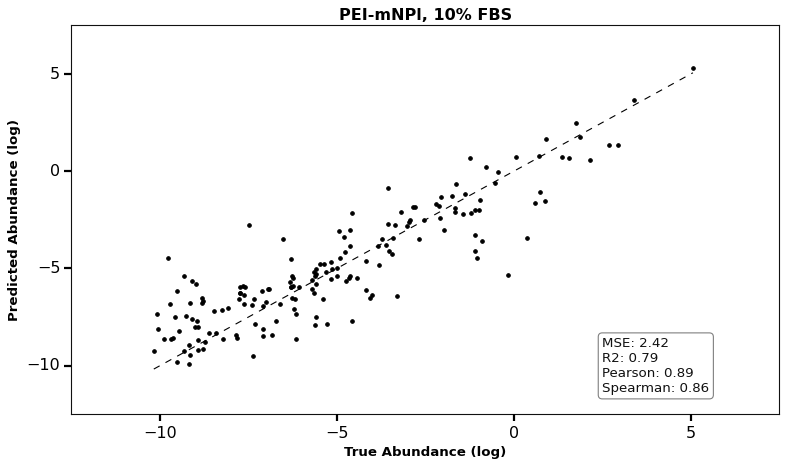

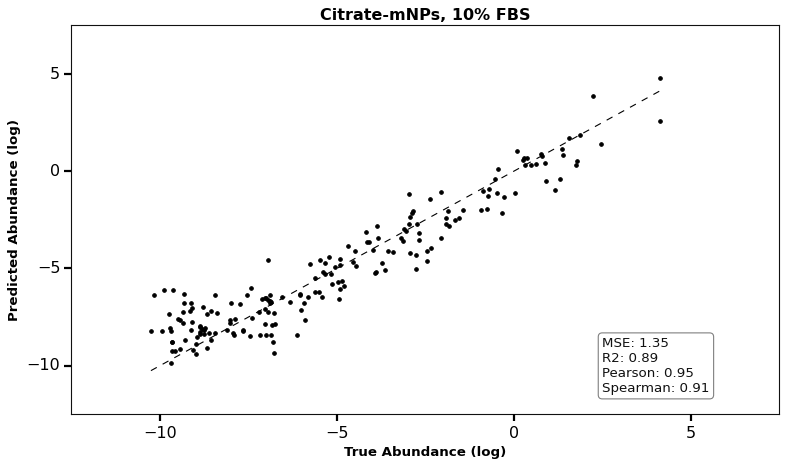

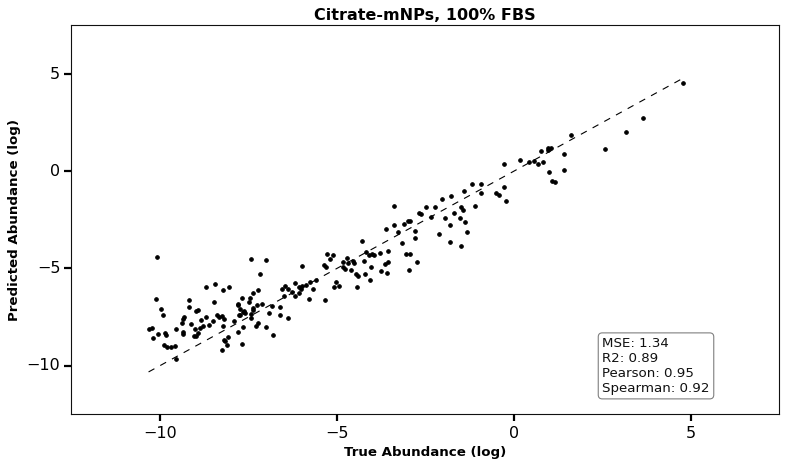

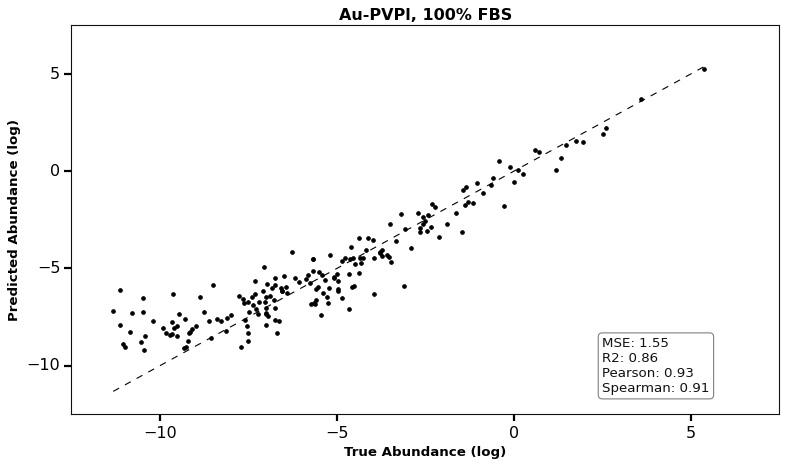

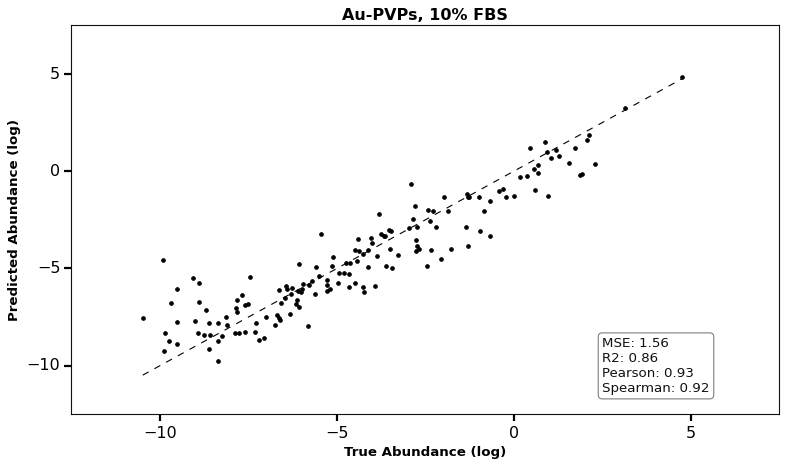

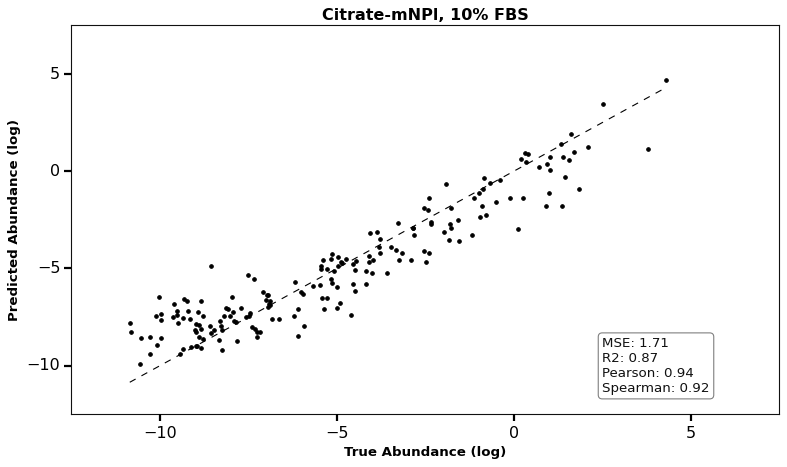

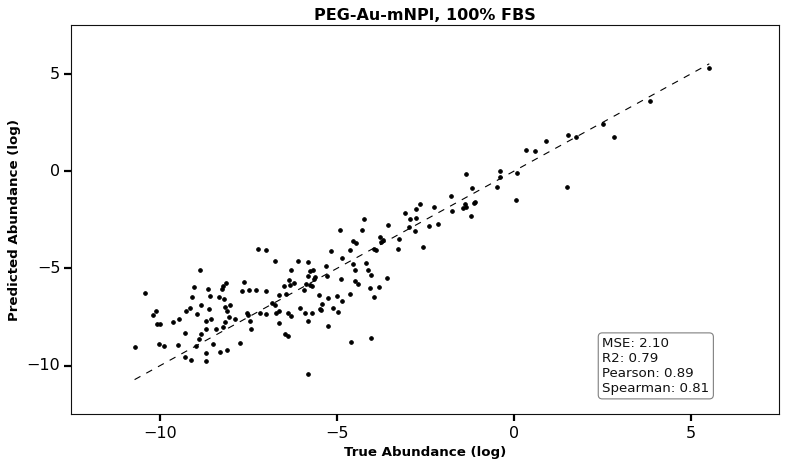

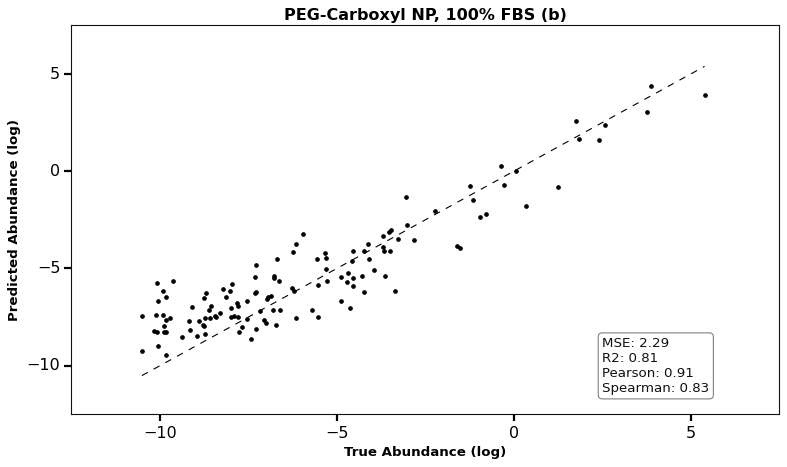

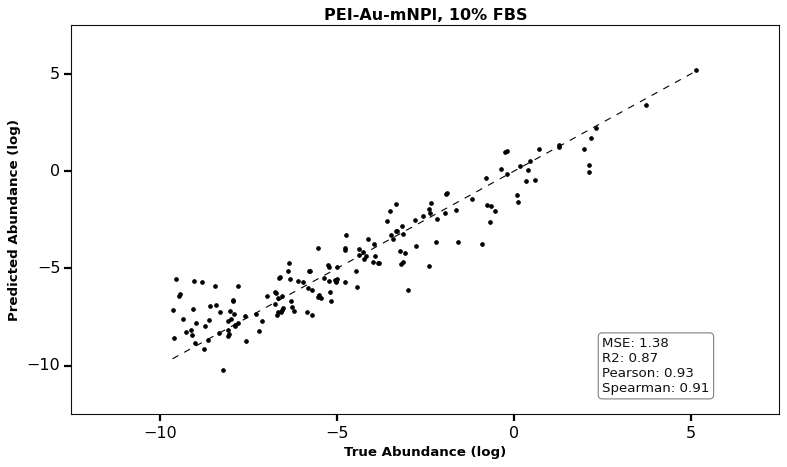

    Pearson  Spearman  R-squared  Mean Squared Error  \
0  0.919776  0.885084   0.833368            1.912289   
0  0.899270  0.862815   0.808518            2.000956   
0  0.814432  0.789559   0.644377            3.768654   
0  0.837633  0.760270   0.687940            3.277404   
0  0.897313  0.861455   0.800168            2.025038   

                                ID  
0               PEI-mNPs, 100% FBS  
0               PEI-mNPl, 100% FBS  
0            PEI-Au-mNPs, 100% FBS  
0  Carboxyl-PS 200 nm NP, 100% FBS  
0                Au-PVPs, 100% FBS  


In [ ]:
npunid_to_full_name = {
    17: "Carboxyl-PS 200 nm NP, 10% FBS",
    18: "Carboxyl-PS 200 nm NP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-Carboxyl NP, 100% FBS",
    35: "PEG-Carboxyl NP, 100% FBS (b)"
}


def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100)

    # Filter out rows with abundance values below zero for train_set
    Min_Abundance = train_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    train_set = train_set[train_set['Abundance'] >= Min_Abundance].copy()

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents a 1D array of target values (class labels)
    label_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in train_set.columns]
    train_set.drop(columns=columns_to_drop, inplace=True)
    selected_features = train_set.columns.tolist()

    # Filter out rows with abundance values below zero for test_set
    Min_Abundance = test_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    test_set = test_set[test_set['Abundance'] >= Min_Abundance].copy()

    label_pred = np.log2(test_set['Abundance'].to_numpy().astype(float))

    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()
    y_train = label_train
    y_test = label_pred

    # Train the classifier
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Creating the figure and axes object with a specified size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set high resolution for clearer output
    plt.rcParams['figure.dpi'] = 300

    # Scatter plot of true vs. predicted values using adjusted color and marker size
    ax.scatter(y_test, y_pred, color='black', s=10)  # Using black for consistency and adjusting marker size

    # Identity line with adjusted color and line style
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

    # Setting labels, title with customized options
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)

    # Add a metrics box to the plot with consistent styling
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Adjusting the tick parameters for consistency
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    # Remove grid lines for a cleaner look
    ax.grid(False)

    # Ensure layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Close the plot explicitly to free up memory
    plt.close()

    results = pd.DataFrame({
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "Mean Squared Error": [mse],
        "ID": name  # This assumes 'name' is intended to be the identifier for the row
    })

    return results

# Manually selected file path to save to
input_strings = ['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_df_Bov Swiss Intensity.xlsx']

for input_string in input_strings:
    df = pd.read_excel(input_string, header=0)

    # Create new evaluation df that will have the results of everything appended to it
    full_eval = pd.DataFrame()

    # Create a list of all unique NPUNID IDs in current df
    np_ids = df['NPUNID'].unique().tolist()
    print(np_ids)

    for np_id in np_ids:
        # Filter df to only include rows with current NPUNID - test set
        current_np = df.loc[df['NPUNID'] == np_id].copy()
        # Filter df to only include rows without current NPUNID - train set
        temp_df = df.loc[df['NPUNID'] != np_id].copy()

        # Get full sample name
        full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

        # Train RFR model to make predictions on current NPUNID entry
        eval = predict_nanoparticles(temp_df, current_np, full_name)

        # Append the test to the full evaluation df
        full_eval = pd.concat([full_eval, eval])

    print(full_eval.head())

# Specific Feature Analysis

% Random Coil (Protein Feaure)

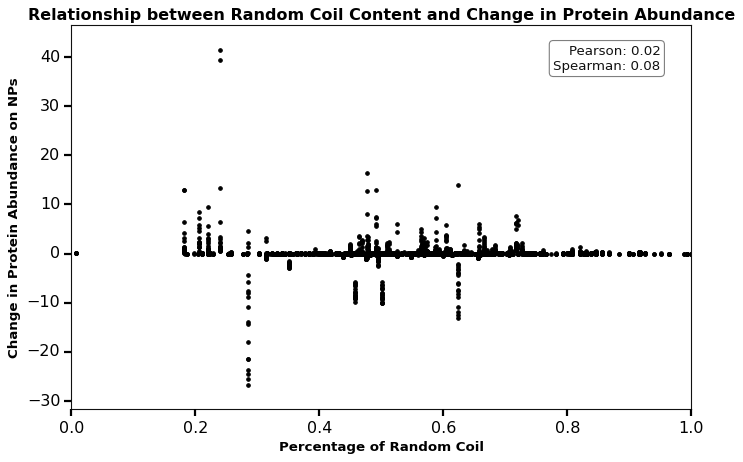

In [ ]:
# Load the provided Excel file
file_path = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_df_Bov Swiss Intensity.xlsx'
df = pd.read_excel(file_path)

# Calculate the change in abundance with respect to the control
df['Abundance_Change'] = df['Abundance'] - df['Abundance_Controls']

# Filter the relevant columns
filtered_df = df[['Entry', 'nsp_secondary_structure_coil', 'Abundance_Change']]

# Set the plotting style
plt.style.use('classic')

# Create the figure and axes object with a specified size and background color
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

# Set high resolution for clearer output
plt.rcParams['figure.dpi'] = 300

# Scatter plot of all data points with adjusted color and marker size
ax.scatter(filtered_df['nsp_secondary_structure_coil'], filtered_df['Abundance_Change'], color='black', s=10)

# Setting labels and title with customized options
ax.set_xlabel('Percentage of Random Coil', fontweight='bold', color='black')
ax.set_ylabel('Change in Protein Abundance on NPs', fontweight='bold', color='black')
ax.set_title('Relationship between Random Coil Content and Change in Protein Abundance', fontweight='bold', color='black')

# Add a correlation metrics box to the plot with consistent styling
pearson_corr = filtered_df['nsp_secondary_structure_coil'].corr(filtered_df['Abundance_Change'])
spearman_corr = filtered_df['nsp_secondary_structure_coil'].corr(filtered_df['Abundance_Change'], method='spearman')
box_text = f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}'
props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
ax.text(0.95, 0.95, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjusting the tick parameters for consistency
ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)

# Adjust y-axis limits to ensure all data points are visible
y_min = filtered_df['Abundance_Change'].min()
y_max = filtered_df['Abundance_Change'].max()
ax.set_ylim(y_min - 5, y_max + 5)
ax.set_xlim(0, 1)

# Remove grid lines for a cleaner look
ax.grid(False)

# Add legend
#ax.legend()

# Show the plot
plt.show()

Collinearity Matrix

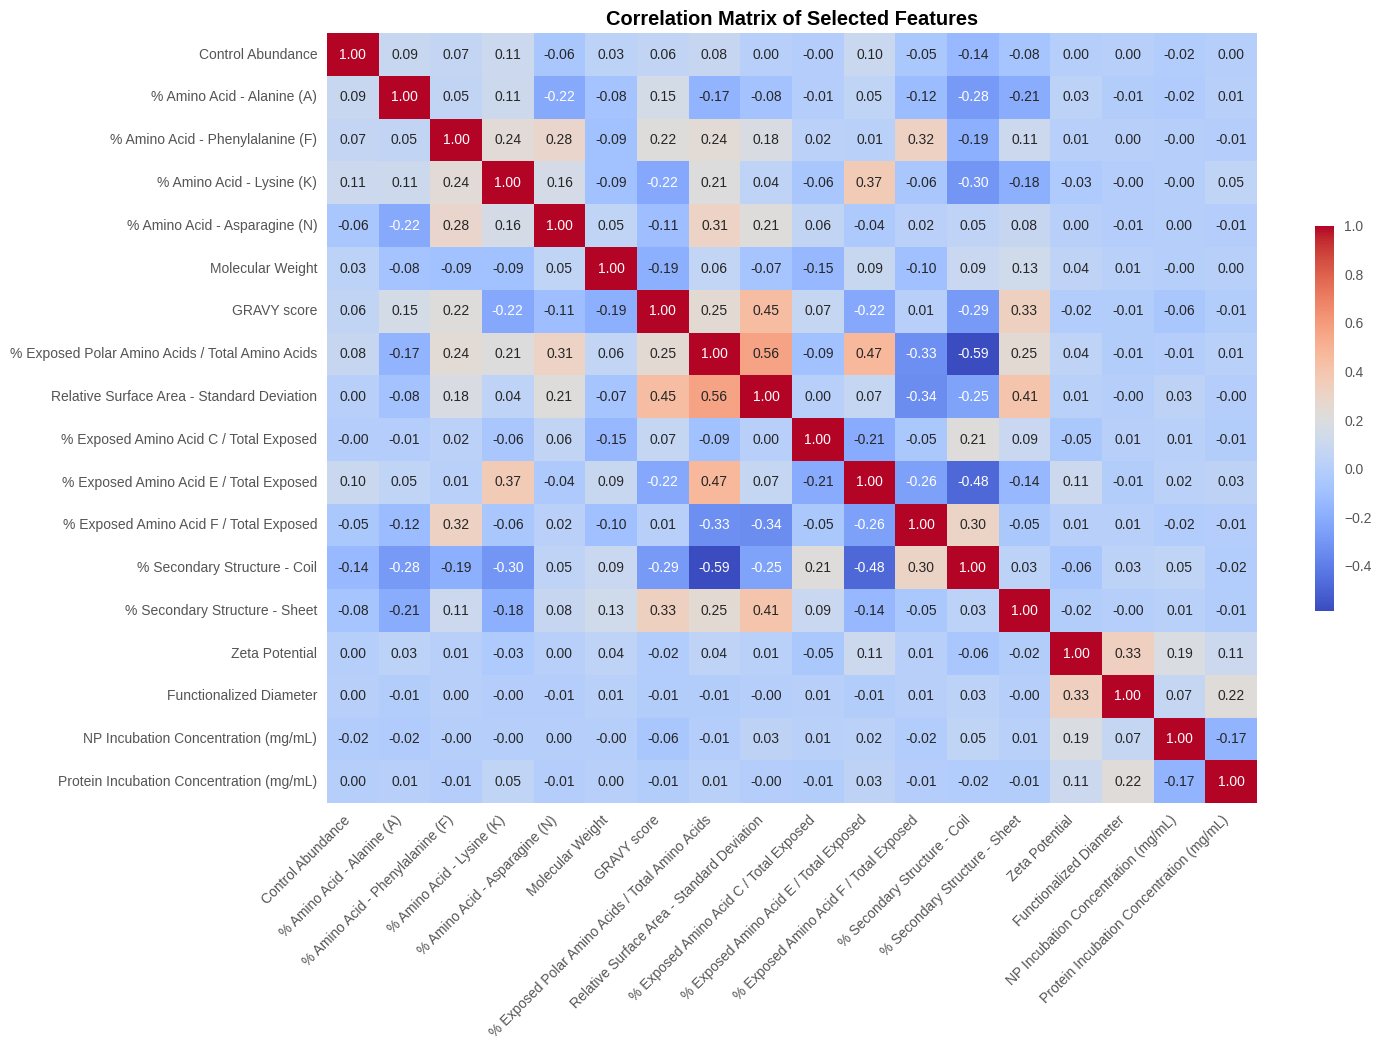

In [ ]:
# Load the provided Excel file
file_path = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_df_Bov Swiss Intensity.xlsx'
df = pd.read_excel(file_path)

# Define the selected features and target variable
selected_features_list = [
    'Abundance_Controls', 'frac_aa_A', 'frac_aa_F', 'frac_aa_K', 'frac_aa_N',
    'molecular_weight', 'gravy', 'fraction_exposed_polar_total', 'rsa_std',
    'fraction_exposed_exposed_C', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F',
    'nsp_secondary_structure_coil', 'nsp_secondary_structure_sheet', 'Zeta Potential',
    'Dh_functionalized', 'NP_incubation Concentration (mg/mL)', 'Incubation Concentration (mg/ml)'
]

selected_features_df = df[selected_features_list]
#X = df[selected_features_list]
#y = df['Abundance']

# Define the dictionary for mapping feature names to their full names
full_name_dict = {
    'Abundance_Controls' : 'Control Abundance',
    'frac_aa_A': '% Amino Acid - Alanine (A)',
    'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
    'frac_aa_K': '% Amino Acid - Lysine (K)',
    'frac_aa_N': '% Amino Acid - Asparagine (N)',
    'molecular_weight': 'Molecular Weight',
    'gravy': 'GRAVY score',
    'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
    'rsa_std': 'Relative Surface Area - Standard Deviation',
    'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
    'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
    'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
    'nsp_secondary_structure_coil': '% Secondary Structure - Coil',
    'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
    'Zeta Potential': 'Zeta Potential',
    'Dh_functionalized': 'Functionalized Diameter',
    'NP_incubation Concentration (mg/mL)': 'NP Incubation Concentration (mg/mL)',
    'Incubation Concentration (mg/ml)': 'Protein Incubation Concentration (mg/mL)',
    'Abundance': 'Protein Abundance'
}

# Map the feature names to their full names, retaining any unmatched columns
selected_features_df.columns = [full_name_dict.get(col, col) for col in selected_features_df.columns]

# Calculate the correlation matrix for the selected features with full names
correlation_matrix_full_names = selected_features_df.corr()

# Create a figure and set the background color to white
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('white')  # Set the background color of the figure to white
ax.set_facecolor('white')  # Set the background color of the axes to white

# Plot the heatmap of the correlation matrix using grayscale colormap
sns.heatmap(correlation_matrix_full_names, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': .5}, ax=ax)

# Set the title
plt.title('Correlation Matrix of Selected Features', fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

# # Extract the relevant columns from the dataframe
# selected_features_df = df[selected_features_list]

# # Calculate the correlation matrix for the selected features
# correlation_matrix = selected_features_df.corr()

# # Create a figure and set the background color to white
# fig, ax = plt.subplots(figsize=(15, 10))
# fig.patch.set_facecolor('white')  # Set the background color of the figure to white
# ax.set_facecolor('white')  # Set the background color of the axes to white

# # Plot the heatmap of the correlation matrix using grayscale colormap
# sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt='.2f', cbar_kws={'shrink': .5}, ax=ax)

# # Set the title
# plt.title('Correlation Matrix of Selected Features')

# # Show the plot
# plt.show()

# # Split the data into training and testing sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# # Train the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100)
# rf_model.fit(X_train, y_train)

# # Get feature importances from the model
# feature_importances = rf_model.feature_importances_
# features = selected_features_list
# importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# # Sort the features by importance
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Plot the feature importances
# plt.figure(figsize=(12, 8))
# fig.patch.set_facecolor('white')
# sns.barplot(x='Importance', y='Feature', data=importance_df)
# plt.title('Feature Importances from Random Forest Model')
# plt.show()

# # Calculate the correlation matrix for the selected features
# correlation_matrix = df[selected_features_list].corr()

# # Plot the heatmap of the correlation matrix
# plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt='.2f')
# plt.title('Correlation Matrix of Selected Features')
# plt.show()

Histogram of Protein Abundance

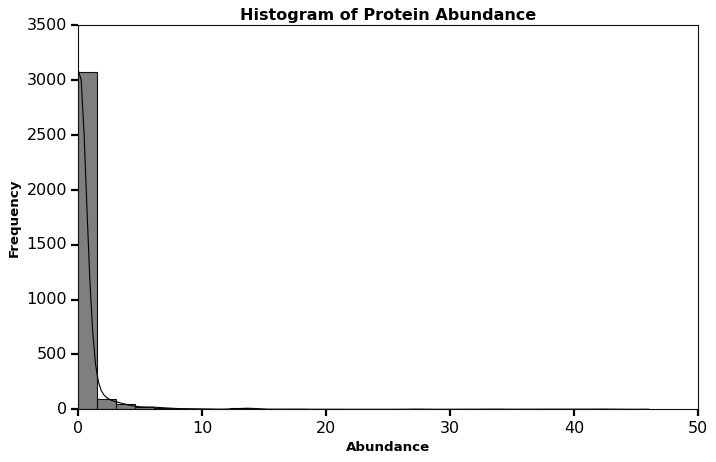

In [ ]:
# Load your data
data = pd.read_excel('/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx')

plt.style.use('classic')

# Create the figure and axes object with a specified size and background color
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

# Set high resolution for clearer output
plt.rcParams['figure.dpi'] = 300

# Histogram with Kernel Density Estimate
sns.histplot(data['Abundance'], bins=30, kde=True, color='black', ax=ax)
ax.set_title('Histogram of Protein Abundance', fontweight='bold', color='black')
ax.set_xlabel('Abundance', fontweight='bold', color='black')
ax.set_ylabel('Frequency', fontweight='bold', color='black')

# Adjusting the tick parameters for consistency
ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)

# Remove grid lines for a cleaner look
ax.grid(False)

# Show the plot
plt.show()


In [ ]:
def predict_file(in_df, name):
  # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100)

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Filter out rows with abundance values below zero
    #Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    #df = df[df['Abundance'] >= Min_Abundance]

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents a 1D array of target values (class labels)
    y_label = np.log2(df['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # List of features for RFR model
    selected_features = df.columns.tolist()
    print(selected_features)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, y_label, test_size=0.1, random_state=42)

    # Train the classifier
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred=model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    #Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Create the figure and axes object with specific figure size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set the figure resolution
    plt.rcParams['figure.dpi'] = 300

    # Plotting the scatter data with customized color and plot line for identity
    ax.scatter(y_test, y_pred, color='black', s=20)  # Adjust marker size with `s`
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Identity line

    # Setting labels and title with customized options
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')

    # Setting plot title
    ax.set_title(f'RFR Model: Predicted vs True Abundance (Log) Bov Swiss-Prot Intensity', fontweight='bold', color='black')

    # Adjusting the tick parameters to match the RFC plot style
    ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)

    # Add a metrics box to the plot with adjusted styling to match the cleaner look
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Remove grid lines for consistency with the first plot's style
    ax.grid(False)

    # Ensure the layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Save the plot
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/{name}_no_AC.png')
    plt.show()

    # Close the plot explicitly to free up memory
    plt.close()



        # NEED TO SAVE: evaluation metrics to excel file


# Initialize an empty list to store threads
threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)
        print(file_path)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        # Create a thread that runs process_file on each Excel file
        thread = threading.Thread(target=predict_file, args=(file_path, name))

        # Append the thread to the list and start it
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")

In [ ]:
def process_file(in_df, name):
    model = RandomForestRegressor(n_estimators=100)

    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()

    y_label = np.log2(df['Abundance'].to_numpy().astype(float))

    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'neg_mean_squared_error'
    keep_columns = ['Abundance', 'NPUNID', 'Entry']
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(100)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg neg_mean_squared_err": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})
    print('start', name)

    for n_features_to_select in range(max_features, min_features, -1):
        print('n_features_to_select', n_features_to_select)
        avg_accuracies = []

        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            assert len(set(train_index) & set(test_index)) == 0, "Overlap found between training and testing sets"

            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            accuracy = mean_squared_error(y_pred, y_test)
            avg_accuracies.append(accuracy)

            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        avg_accuracy = np.mean(avg_accuracies)
        std_dev = np.std(avg_accuracies)

        combined_score = avg_accuracy + std_dev + (n_features_to_select / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features_to_select, avg_accuracy, std_dev, ", ".join(df.columns), combined_score]

        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score < current_score:
            current_score = combined_score
            best_features = df.columns.tolist()

    print("Best Feature Names:", best_features)

    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/RFECV_RFR_results_{name}_ANOVA_no_AC.csv', index=False)
    feat_list = best_features + keep_columns

    df = df_original[best_features].copy()
    RFR_scores, feats = scorer(df, y_label, model, identifier=identifier, folds=n_splits)

    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/Feats_RFECV_{name}_ANOVA_no_AC.xlsx', index=False)
    RFR_scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/Scores_RFECV_{name}_ANOVA_no_AC.xlsx', index=False)

    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_{name}_ANOVA_no_AC.csv', index=False)

    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    ranked_features = rank_features_by_anova(df[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)
    top_10_features.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/ANOVA_top_features_{name}_no_AC')
    plot_top_features(top_10_features, name)
    print(top_10_features)

    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    n_features = df_full_results["Number of features"]
    mse_mean = df_full_results["Avg neg_mean_squared_err"]
    mse_std = df_full_results["Std dev"]

    ax.plot(n_features, mse_mean, label='Negative MSE', color='black', marker='o', markersize=4)
    ax.fill_between(n_features, mse_mean - mse_std, mse_mean + mse_std, color='black', alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Negative Mean Squared Error', fontweight='bold', color='black')
    ax.set_title(f'RFR Model: RFECV Results for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    ax.tick_params(axis='both', which='both', direction='out', length=6, width=2, colors='black', labelsize='large', labelcolor='black', bottom=True, top=False, left=True, right=False)
    ax.grid(False)
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/RFECV_plot_{name}_ANOVA_no_AC.png')
    plt.show()
    plt.close()
    print(name, 'done')

threads = []

for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        file_path = os.path.join(input_directory, file)
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)
        thread = threading.Thread(target=process_file, args=(file_path, name))
        threads.append(thread)
        thread.start()

for thread in threads:
    thread.join()

print("All files processed!")

In [ ]:
# Want the file that contains the previously determined important features
# Manually selected file path to save to
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity' # RFR folder in Output_DataFrames

file_beginning = 'df_RFECV_RFR_'
file_group = 'Bov Swiss'
file_ending = 'Intensity_no_AC_ANOVA_no_AC.csv' # options are 'Intensity.csv', 'Top3.csv', 'iBAQ.csv'
files = []

for file in os.listdir(input_directory):
    if file.startswith(file_beginning) and file_group in file and file_ending in file:
        files.append(file)

print("Original CSV files:", files)

# Convert items in files list to .xlsx file type
for i, csv_file in enumerate(files):
    file_path = os.path.join(input_directory, csv_file)  # Full path to the CSV file
    df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame

    # Construct Excel file name
    excel_file = csv_file.replace('.csv', '.xlsx')
    excel_path = os.path.join(input_directory, excel_file)  # Full path to the Excel file

    # Save the DataFrame to an Excel file
    df.to_excel(excel_path, index=False)  # Set index=False to not write row indices

    # Update the file name in the list
    files[i] = excel_file

    print(f'Converted {csv_file} to {excel_file}')

# Print the updated list of files, now with .xlsx extensions
print("Updated list with Excel files:", files)

Original CSV files: ['df_RFECV_RFR_df_Bov Swiss Intensity_no_AC_ANOVA_no_AC.csv']
Converted df_RFECV_RFR_df_Bov Swiss Intensity_no_AC_ANOVA_no_AC.csv to df_RFECV_RFR_df_Bov Swiss Intensity_no_AC_ANOVA_no_AC.xlsx
Updated list with Excel files: ['df_RFECV_RFR_df_Bov Swiss Intensity_no_AC_ANOVA_no_AC.xlsx']
